In [1]:
# THIS IS PCA WITH INCLUDING NUMBER OF GOALS IN ADJACENCY MATRIX

import os
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from ripser import ripser


In [2]:
# Function to adjust goals based on match time
def adjust_goals(goals, time):
    return (goals / time) * 60  # Scale to a 60-minute match

# Function to parse the filename and extract team, goals, and time
def parse_filename(filename):
    parts = filename.split('_')
    team_name = parts[1]
    goals = int(parts[2])
    time = int(parts[3].replace('.json', ''))
    return team_name, goals, time

# Construct adjacency matrix and include adjusted goals
def construct_adjacency_matrix(game_data, adjusted_goals):
    G = nx.Graph()

    # Step 1: Find the maximum pass count to normalize edge weights
    max_count = max(pass_info["count"] for player in game_data for pass_info in player.get("passes", []))

    # Step 2: Add nodes for each player, including their adjusted goals
    for player in game_data:
        G.add_node(player['name'], pos=(player['x'], player['y']), adjusted_goals=adjusted_goals)
    
    # Step 3: Add edges with normalized weights (divide by max_count)
    for player in game_data:
        for pass_info in player.get("passes", []):
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            # Normalize edge weight by dividing by the max pass count
            edge_weight = count / max_count

            # Add edge to the graph with normalized weight
            G.add_edge(player1, player2, weight=edge_weight)

    return G

# Load data from files and construct persistence diagrams
folder_path = '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/'

# Get a list of all files in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.json')]

# Load all match data and construct persistence diagrams
data = []
adjusted_goals_list = []
max_feature_length = 0  # Track the maximum length of features

for file_path in file_paths:
    team_name, goals, time = parse_filename(file_path)
    adjusted_goals = adjust_goals(goals, time)
    adjusted_goals_list.append(adjusted_goals)  # Store adjusted goals as target variable
    
    # Load the game data
    with open(file_path, 'r') as f:
        game_data = json.load(f)
    
    # Construct the adjacency matrix with adjusted goals
    G = construct_adjacency_matrix(game_data, adjusted_goals)
    
    # Convert graph to adjacency matrix and calculate persistence diagram
    adj_matrix = nx.to_numpy_array(G)
    persistence_diagrams = ripser(adj_matrix, distance_matrix=True)['dgms']
    
    # Extract features from persistence diagrams
    features = []
    for diagram in persistence_diagrams:
        # Ensure the diagram is not empty
        if diagram.size > 0:  
            diagram = np.array(diagram)  # Diagram contains points
            lifespan = diagram[:, 1] - diagram[:, 0]  # Calculate lifespan (death - birth)
            features.append(lifespan)
            max_feature_length = max(max_feature_length, len(lifespan))  # Update the max feature length
        else:
            features.append(np.zeros(1))  # Empty diagram, append a zero vector

    data.append(features)

# Pad the features to ensure they are of equal length
padded_data = []
for feature in data:
    padded_feature = []
    for f in feature:
        # Pad with zeros to the maximum feature length
        padded_feature.append(np.pad(f, (0, max_feature_length - len(f)), mode='constant'))
    padded_data.append(np.array(padded_feature))

# Convert to a numpy array and standardize the features
features = np.array(padded_data)
scaler = StandardScaler()

# Check for NaN or infinity values
if np.any(np.isnan(features)) or np.any(np.isinf(features)):
    print("Features contain NaN or Infinity values.")
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

features_scaled = scaler.fit_transform(features.reshape(features.shape[0], -1))  # Flatten for scaling

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

Features contain NaN or Infinity values.


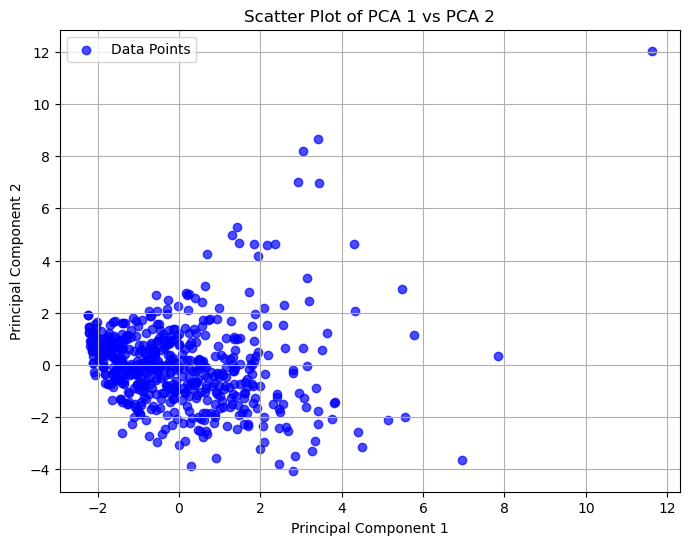

In [3]:
# Plot PCA 1 against PCA 2
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.7, color='blue', label='Data Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PCA 1 vs PCA 2')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error: 0.7408966569305487
R-squared: 0.033718337459044734


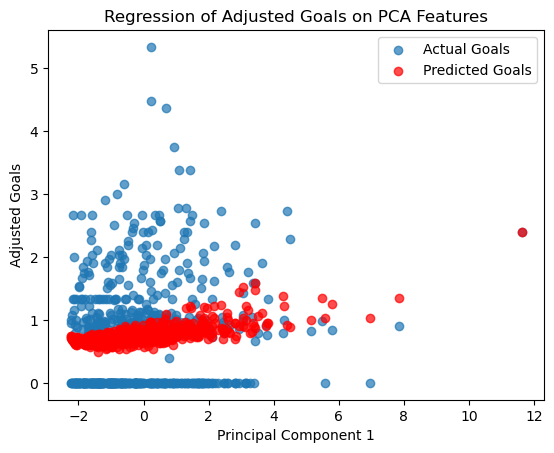

In [4]:
# Convert adjusted goals to numpy array for regression
adjusted_goals_array = np.array(adjusted_goals_list)

# Train a linear regression model
regressor = LinearRegression()
regressor.fit(features_pca, adjusted_goals_array)

# Predict using the regression model
predictions = regressor.predict(features_pca)

# Evaluate the regression model
mse = mean_squared_error(adjusted_goals_array, predictions)
r2 = r2_score(adjusted_goals_array, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the PCA features with regression line
plt.scatter(features_pca[:, 0], adjusted_goals_array, label='Actual Goals', alpha=0.7)
plt.scatter(features_pca[:, 0], predictions, label='Predicted Goals', alpha=0.7, color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Adjusted Goals')
plt.legend()
plt.title('Regression of Adjusted Goals on PCA Features')
plt.show()

# Final regression analysis evaluates whether PCA features can effectively predict adjusted goals.
# By plotting PCA 1 against adjusted goals, you are exploring whether the strongest variation in the passing network data correlates with team scoring performance.

Mean Squared Error (PCA 2): 0.7550607342591038
R-squared (PCA 2): 0.015245466699853494


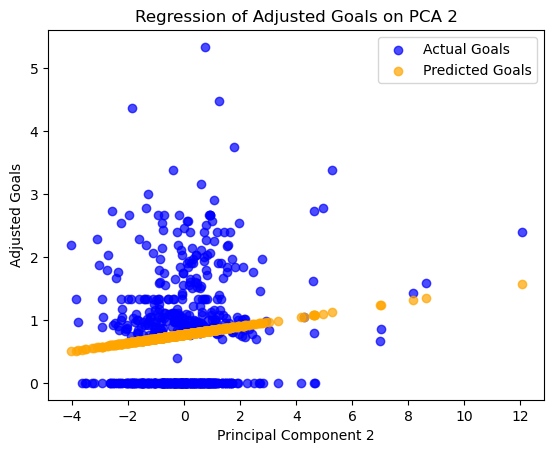

In [5]:
# Train a linear regression model for PCA 2 against adjusted goals
regressor_pca2 = LinearRegression()
regressor_pca2.fit(features_pca[:, 1].reshape(-1, 1), adjusted_goals_array)

# Predict using the regression model
predictions_pca2 = regressor_pca2.predict(features_pca[:, 1].reshape(-1, 1))

# Evaluate the regression model
mse_pca2 = mean_squared_error(adjusted_goals_array, predictions_pca2)
r2_pca2 = r2_score(adjusted_goals_array, predictions_pca2)

# Print results
print(f"Mean Squared Error (PCA 2): {mse_pca2}")
print(f"R-squared (PCA 2): {r2_pca2}")

# Visualization: PCA 2 vs Adjusted Goals with Prediction Points
plt.scatter(features_pca[:, 1], adjusted_goals_array, label='Actual Goals', alpha=0.7, color='blue')
plt.scatter(features_pca[:, 1], predictions_pca2, label='Predicted Goals', alpha=0.7, color='orange')
plt.xlabel('Principal Component 2')
plt.ylabel('Adjusted Goals')
plt.legend()
plt.title('Regression of Adjusted Goals on PCA 2')
plt.show()


Mean Squared Error (Combined PCA 1 and PCA 2): 0.7408966569305487
R-squared (Combined PCA 1 and PCA 2): 0.033718337459044734


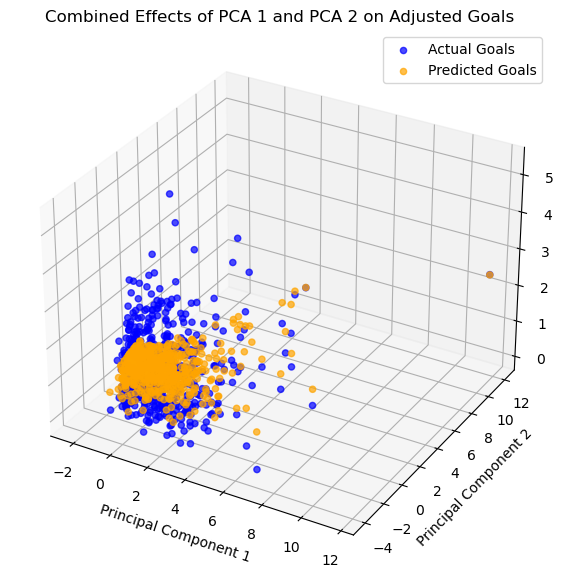

In [6]:
# Train a linear regression model for PCA 1 and PCA 2 combined against adjusted goals
regressor_combined = LinearRegression()
regressor_combined.fit(features_pca[:, :2], adjusted_goals_array)

# Predict using the regression model
predictions_combined = regressor_combined.predict(features_pca[:, :2])

# Evaluate the regression model
mse_combined = mean_squared_error(adjusted_goals_array, predictions_combined)
r2_combined = r2_score(adjusted_goals_array, predictions_combined)

# Print evaluation metrics
print(f"Mean Squared Error (Combined PCA 1 and PCA 2): {mse_combined}")
print(f"R-squared (Combined PCA 1 and PCA 2): {r2_combined}")

# Visualization: 3D scatter plot for actual and predicted goals
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for actual goals
ax.scatter(features_pca[:, 0], features_pca[:, 1], adjusted_goals_array, label='Actual Goals', alpha=0.7, color='blue')

# Scatter plot for predicted goals
ax.scatter(features_pca[:, 0], features_pca[:, 1], predictions_combined, label='Predicted Goals', alpha=0.7, color='orange')

# Labels and legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Adjusted Goals')
plt.title('Combined Effects of PCA 1 and PCA 2 on Adjusted Goals')
ax.legend()

plt.show()

Mean Squared Error (PCA 2): 0.7550607342591038
R-squared (PCA 2): 0.015245466699853494


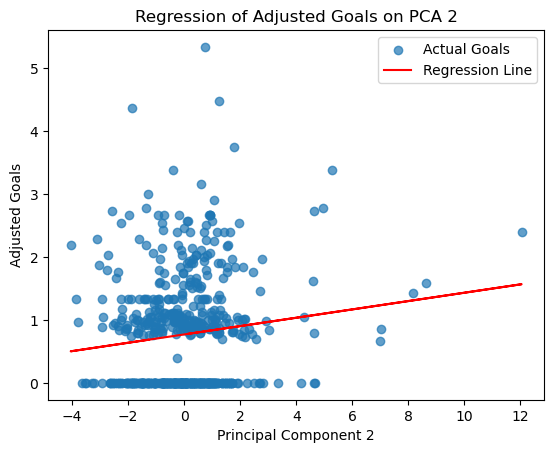

In [7]:

# Train a linear regression model for PCA 2 against adjusted goals
regressor_pca2 = LinearRegression()
regressor_pca2.fit(features_pca[:, 1].reshape(-1, 1), adjusted_goals_array)

# Predict using the regression model
predictions_pca2 = regressor_pca2.predict(features_pca[:, 1].reshape(-1, 1))

# Evaluate the regression model
mse_pca2 = mean_squared_error(adjusted_goals_array, predictions_pca2)
r2_pca2 = r2_score(adjusted_goals_array, predictions_pca2)

print(f"Mean Squared Error (PCA 2): {mse_pca2}")
print(f"R-squared (PCA 2): {r2_pca2}")

# Plot PCA 2 against adjusted goals with regression line
plt.scatter(features_pca[:, 1], adjusted_goals_array, label='Actual Goals', alpha=0.7)
plt.plot(features_pca[:, 1], predictions_pca2, label='Regression Line', color='red')
plt.xlabel('Principal Component 2')
plt.ylabel('Adjusted Goals')
plt.legend()
plt.title('Regression of Adjusted Goals on PCA 2')
plt.show()

Mean Squared Error (PCA 1): 0.7525861215547299
R-squared (PCA 1): 0.01847287075919113


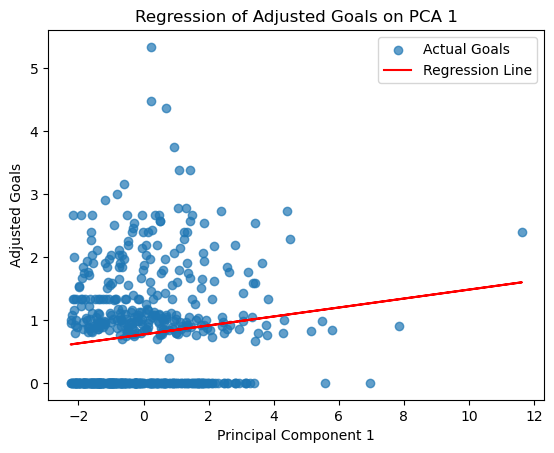

In [8]:
# Train a linear regression model for PCA 1 against adjusted goals
regressor_pca1 = LinearRegression()
regressor_pca1.fit(features_pca[:, 0].reshape(-1, 1), adjusted_goals_array)

# Predict using the regression model
predictions_pca1 = regressor_pca1.predict(features_pca[:, 0].reshape(-1, 1))

# Evaluate the regression model
mse_pca1 = mean_squared_error(adjusted_goals_array, predictions_pca1)
r2_pca1 = r2_score(adjusted_goals_array, predictions_pca1)

print(f"Mean Squared Error (PCA 1): {mse_pca1}")
print(f"R-squared (PCA 1): {r2_pca1}")

# Plot PCA 1 against adjusted goals with regression line
plt.scatter(features_pca[:, 0], adjusted_goals_array, label='Actual Goals', alpha=0.7)
plt.plot(features_pca[:, 0], predictions_pca1, label='Regression Line', color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Adjusted Goals')
plt.legend()
plt.title('Regression of Adjusted Goals on PCA 1')
plt.show()


Mean Squared Error (PCA 1): 0.7525861215547299
R-squared (PCA 1): 0.01847287075919113
Mean Squared Error (PCA 2): 0.7550607342591038
R-squared (PCA 2): 0.015245466699853494


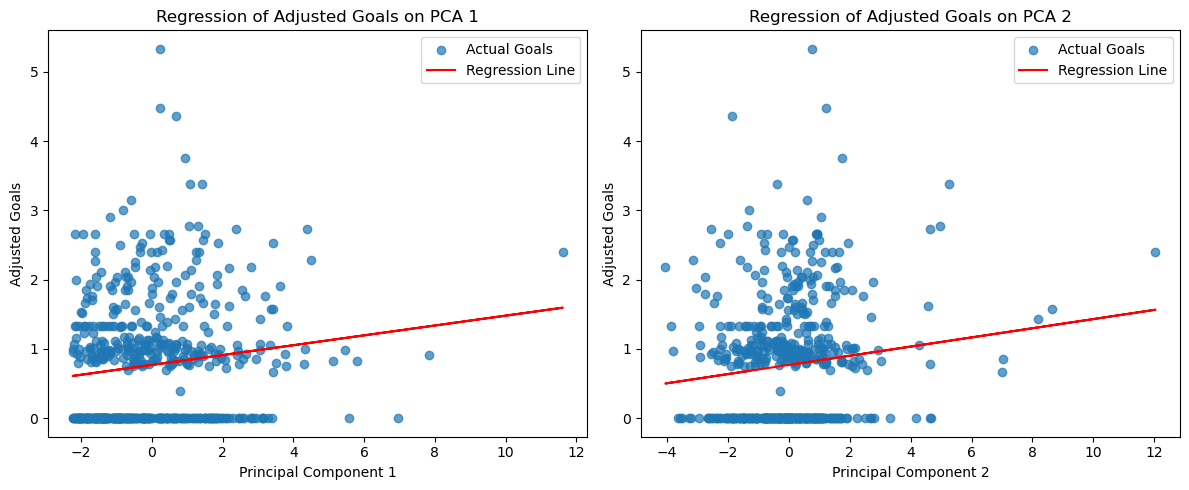

In [9]:
# Train a linear regression model for PCA 1 against adjusted goals
regressor_pca1 = LinearRegression()
regressor_pca1.fit(features_pca[:, 0].reshape(-1, 1), adjusted_goals_array)

# Predict using the regression model
predictions_pca1 = regressor_pca1.predict(features_pca[:, 0].reshape(-1, 1))

# Evaluate the regression model
mse_pca1 = mean_squared_error(adjusted_goals_array, predictions_pca1)
r2_pca1 = r2_score(adjusted_goals_array, predictions_pca1)

# Train a linear regression model for PCA 2 against adjusted goals
regressor_pca2 = LinearRegression()
regressor_pca2.fit(features_pca[:, 1].reshape(-1, 1), adjusted_goals_array)

# Predict using the regression model
predictions_pca2 = regressor_pca2.predict(features_pca[:, 1].reshape(-1, 1))

# Evaluate the regression model
mse_pca2 = mean_squared_error(adjusted_goals_array, predictions_pca2)
r2_pca2 = r2_score(adjusted_goals_array, predictions_pca2)

# Print evaluation metrics
print(f"Mean Squared Error (PCA 1): {mse_pca1}")
print(f"R-squared (PCA 1): {r2_pca1}")
print(f"Mean Squared Error (PCA 2): {mse_pca2}")
print(f"R-squared (PCA 2): {r2_pca2}")

# Plot PCA 1 against adjusted goals with regression line
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], adjusted_goals_array, label='Actual Goals', alpha=0.7)
plt.plot(features_pca[:, 0], predictions_pca1, label='Regression Line', color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Adjusted Goals')
plt.legend()
plt.title('Regression of Adjusted Goals on PCA 1')

# Plot PCA 2 against adjusted goals with regression line
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 1], adjusted_goals_array, label='Actual Goals', alpha=0.7)
plt.plot(features_pca[:, 1], predictions_pca2, label='Regression Line', color='red')
plt.xlabel('Principal Component 2')
plt.ylabel('Adjusted Goals')
plt.legend()
plt.title('Regression of Adjusted Goals on PCA 2')

plt.tight_layout()
plt.show()


Mean Squared Error (Combined PCA 1 and PCA 2): 0.7408966569305487
R-squared (Combined PCA 1 and PCA 2): 0.033718337459044734


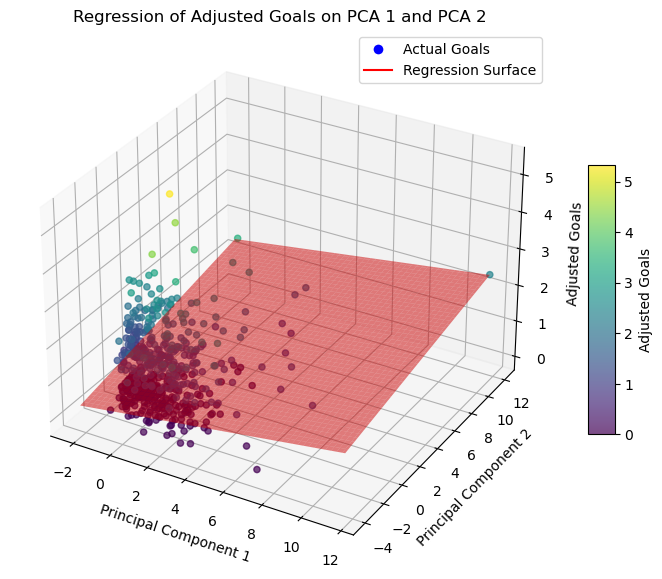

In [10]:
# Train a linear regression model for PCA 1 and PCA 2 combined against adjusted goals
regressor_combined = LinearRegression()
regressor_combined.fit(features_pca[:, :2], adjusted_goals_array)

# Predict using the regression model
predictions_combined = regressor_combined.predict(features_pca[:, :2])

# Evaluate the regression model
mse_combined = mean_squared_error(adjusted_goals_array, predictions_combined)
r2_combined = r2_score(adjusted_goals_array, predictions_combined)

print(f"Mean Squared Error (Combined PCA 1 and PCA 2): {mse_combined}")
print(f"R-squared (Combined PCA 1 and PCA 2): {r2_combined}")

# 3D scatter plot with PCA 1, PCA 2, and adjusted goals
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], adjusted_goals_array, 
                      label='Actual Goals', c=adjusted_goals_array, cmap='viridis', alpha=0.7)

# Add predicted values as a surface
pca1_grid, pca2_grid = np.meshgrid(
    np.linspace(features_pca[:, 0].min(), features_pca[:, 0].max(), 100),
    np.linspace(features_pca[:, 1].min(), features_pca[:, 1].max(), 100)
)
predicted_surface = regressor_combined.predict(
    np.c_[pca1_grid.ravel(), pca2_grid.ravel()]
).reshape(pca1_grid.shape)

ax.plot_surface(pca1_grid, pca2_grid, predicted_surface, alpha=0.5, color='red')

# Labels and legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Adjusted Goals')
plt.title('Regression of Adjusted Goals on PCA 1 and PCA 2')

# Create custom legend
scatter_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Actual Goals')
surface_handle = plt.Line2D([0], [0], linestyle='-', color='red', label='Regression Surface')
ax.legend(handles=[scatter_handle, surface_handle])

# Add color bar for scatter plot
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Adjusted Goals')

plt.show()
